## Ebola infected Macaque Sample Composition Trajectory Identification

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [1]:
import anndata
import matplotlib.pylab as plt
import torch
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

# Configuration

In [2]:
n_iters = 20_000

# Load data

In [3]:
location_fascicularis = '/home/nbarkas/disk2/deconvolution_method/datasets/nhp_fascicularis_atlas/h5ad/'

h5ad_paths = {
    # Ebov Datasets
    "bulk_blood": "ebov_bulk.h5ad",
    "sc_blood": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad",
    "bulk_all": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/all_ebov_bulk.h5ad",
    
    
    # fascicularis
    "sc_adrenal": f"{location_fascicularis}/Adrenal_gland.h5ad",
    "sc_cerebellum": f"{location_fascicularis}/Cerebellum.h5ad",
    "sc_kidney": f"{location_fascicularis}/Kidney.h5ad",
    "sc_liver": f"{location_fascicularis}/Liver.h5ad",
    "sc_lung": f"{location_fascicularis}/Lung.h5ad",
    "sc_lymph_node": f"{location_fascicularis}/Lymph_node.h5ad",
    "sc_neocortex": f"{location_fascicularis}/Neocortex.h5ad",
    "sc_pbmc": f"{location_fascicularis}/pbmc.h5ad",
    "sc_skin": f"{location_fascicularis}/Skin.h5ad",
    "sc_spleen": f"{location_fascicularis}/Spleen.h5ad",
    "sc_subcutaneous_adipose": f"{location_fascicularis}/Subcutaneous_adipose.h5ad",
    "sc_testis": f"{location_fascicularis}/Testis.h5ad",
    "sc_thyroid": f"{location_fascicularis}/Thyroid_gland.h5ad",
    "sc_uterus": f"{location_fascicularis}/Uterus.h5ad",
    "sc_vagina": f"{location_fascicularis}/Vagina.h5ad",
}

In [4]:
with open(h5ad_paths['bulk_all'], 'rb') as fh:
    all_bulk_anndata = anndata.read_h5ad(fh)

In [5]:
with open(h5ad_paths['sc_spleen'], 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['dpi_time'] >=0,]
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['full.tissue'] == 'Spleen',]

In [7]:
all_bulk_anndata.var.gene = all_bulk_anndata.var.gene.astype(str)
all_bulk_anndata.var = all_bulk_anndata.var.set_index('gene')

Trying to set attribute `.var` of view, copying.


In [8]:
datatype_param = DeconvolutionDatatypeParametrization()

In [9]:
ebov_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Abbreviation",
        bulk_anndata = all_bulk_anndata,
        bulk_time_col = "dpi_time",
        feature_selection_method = 'overdispersed_bulk_and_high_sc'
    )
)

log_sc_cutoff: 2
3670 genes selected


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.07774e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


# Run Deconvolution

In [10]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolutionModel(
    dataset=ebov_dataset,
    trajectory_model_type='gp',
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
    types=datatype_param
)

In [11]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000, clear_param_store=False)

[step: 0, time: 1 s ] loss: 16679198.14
[step: 1000, time: 53 s ] loss: 3932477.41
[step: 2000, time: 107 s ] loss: 1602926.15
[step: 3000, time: 162 s ] loss: 942084.78
[step: 4000, time: 216 s ] loss: 697636.36
[step: 5000, time: 280 s ] loss: 582516.43
[step: 6000, time: 346 s ] loss: 524836.25
[step: 7000, time: 405 s ] loss: 494056.57
[step: 8000, time: 471 s ] loss: 477198.21
[step: 9000, time: 533 s ] loss: 468481.42
[step: 10000, time: 584 s ] loss: 463438.52
[step: 11000, time: 633 s ] loss: 460649.36
[step: 12000, time: 673 s ] loss: 459163.30
[step: 13000, time: 713 s ] loss: 458080.31
[step: 14000, time: 754 s ] loss: 457456.98
[step: 15000, time: 795 s ] loss: 456976.44
[step: 16000, time: 835 s ] loss: 456689.21
[step: 17000, time: 875 s ] loss: 456472.25
[step: 18000, time: 913 s ] loss: 456128.90
[step: 19000, time: 950 s ] loss: 456065.72


# Examine Outputs

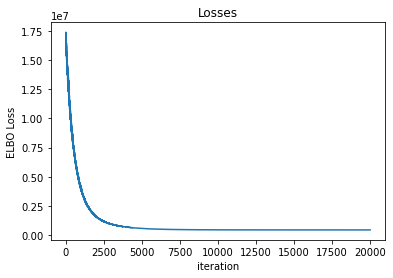

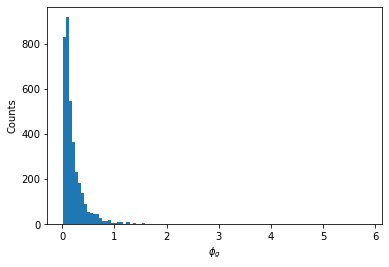

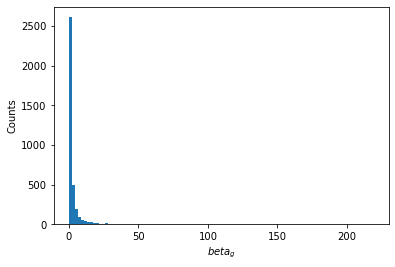

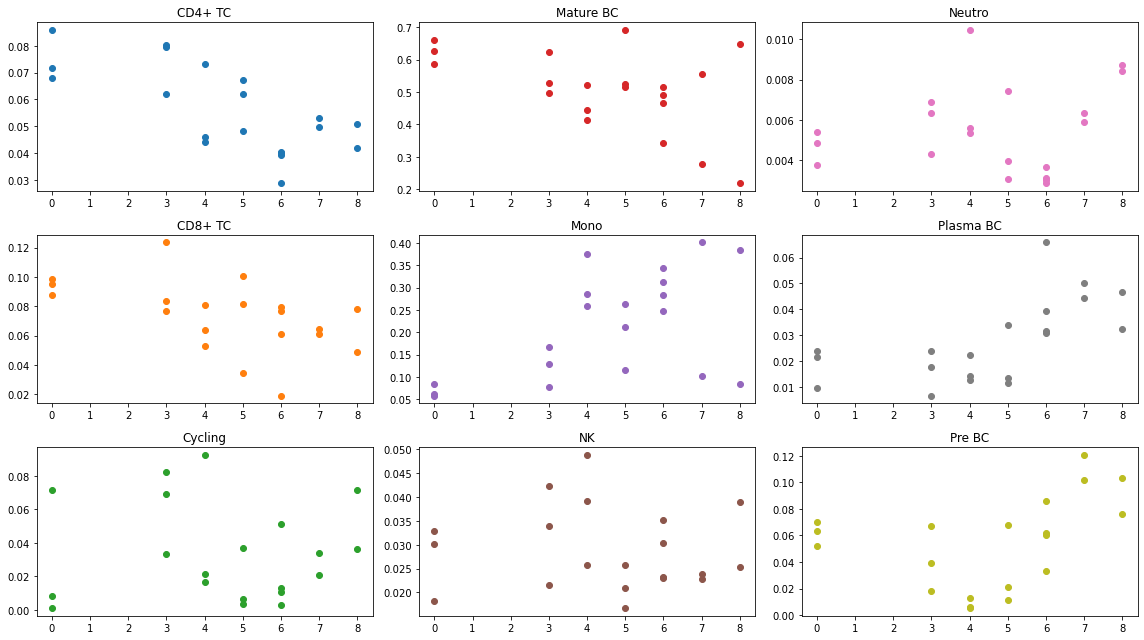

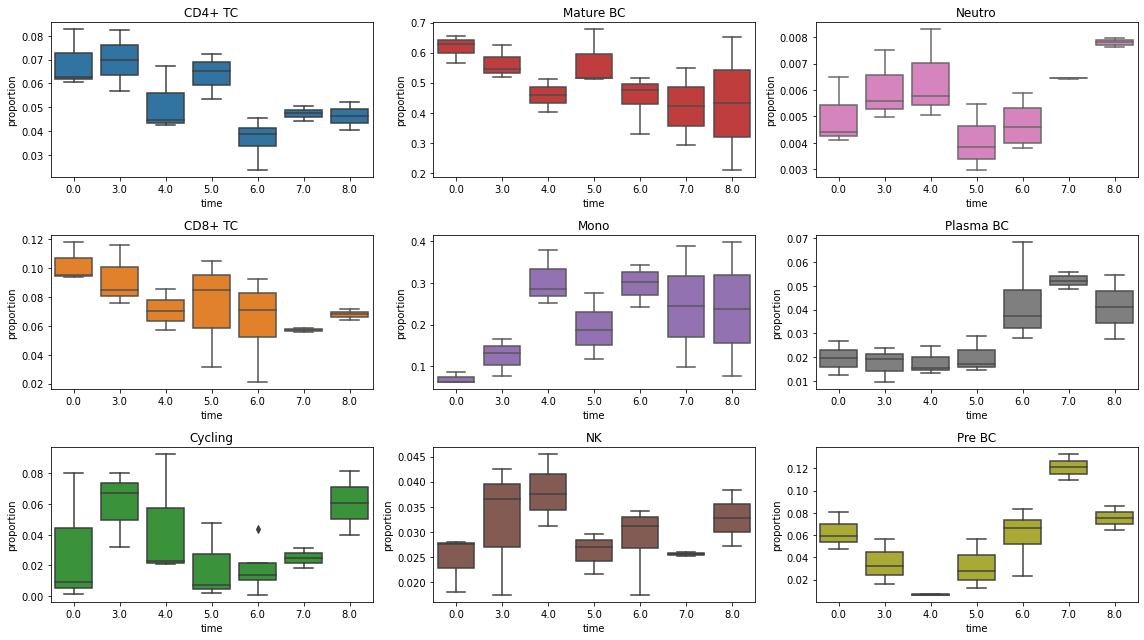

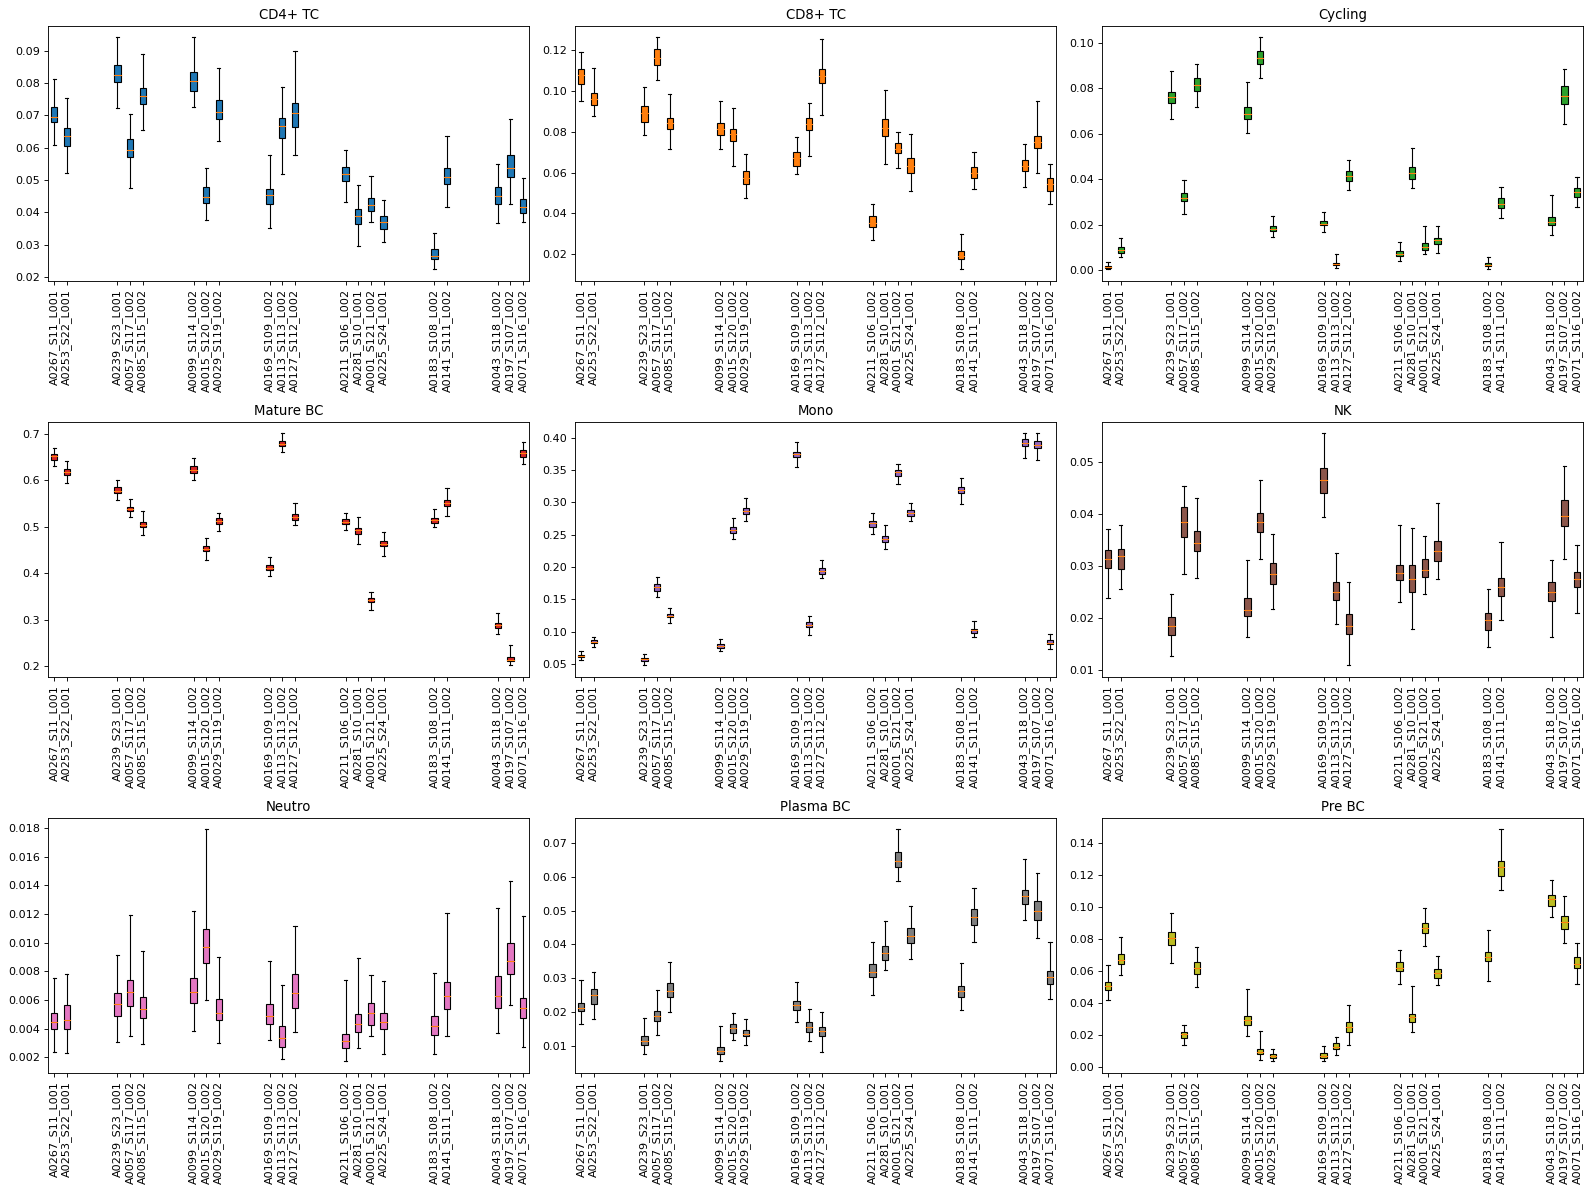

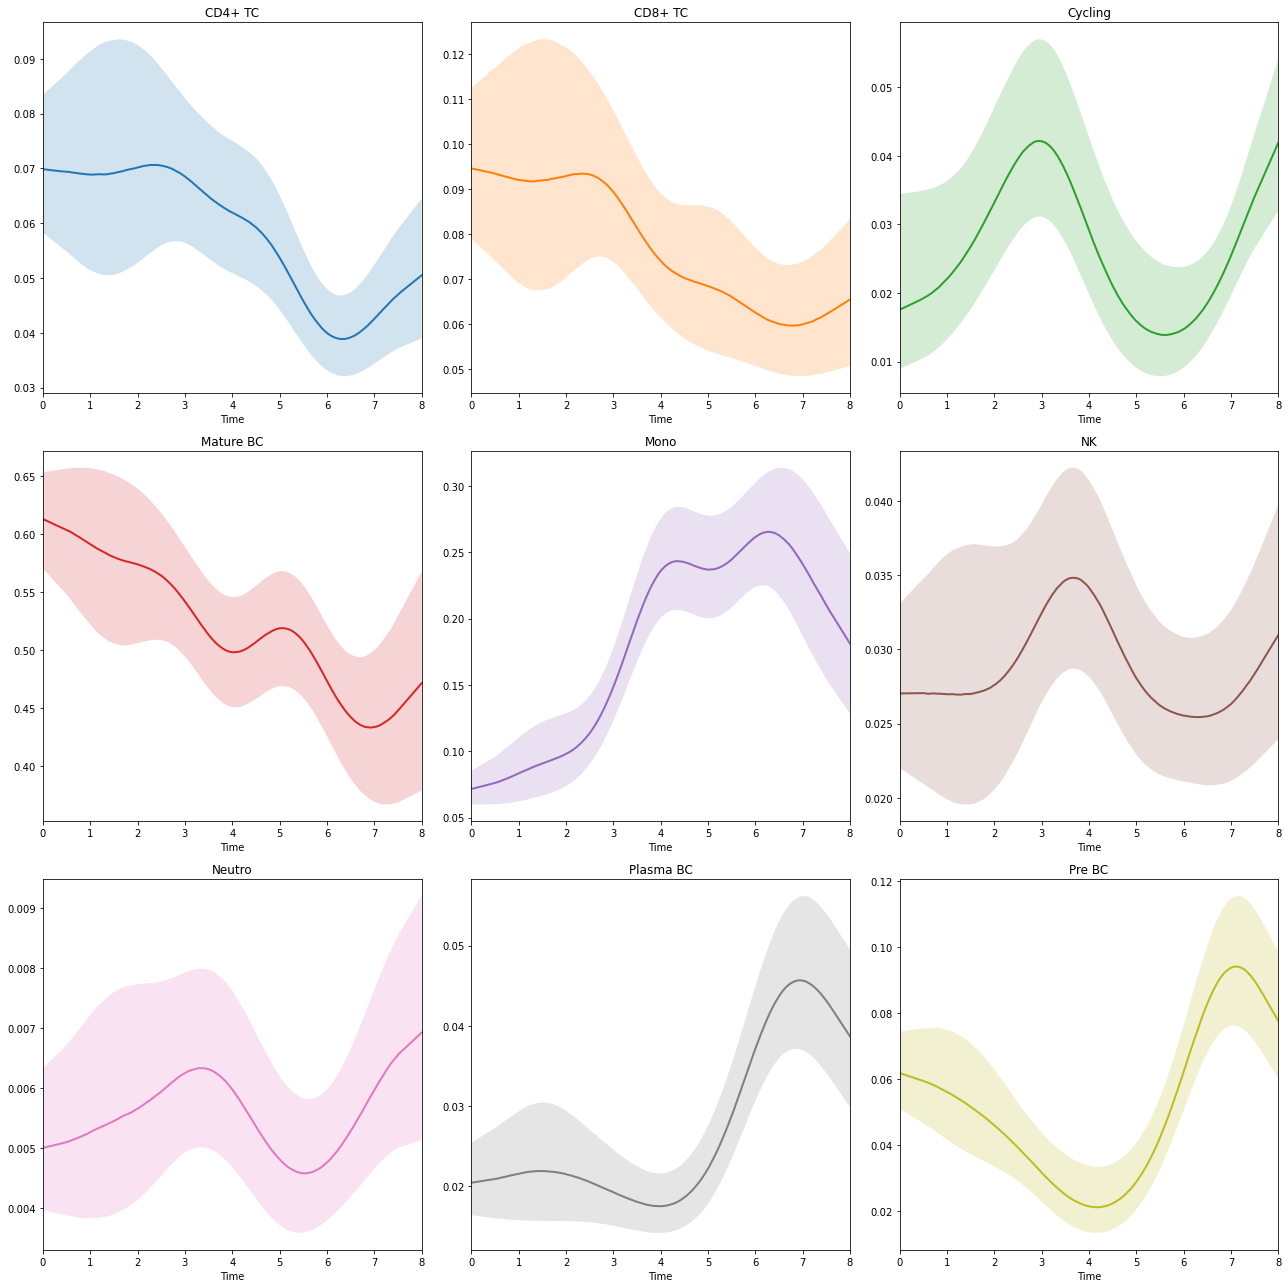

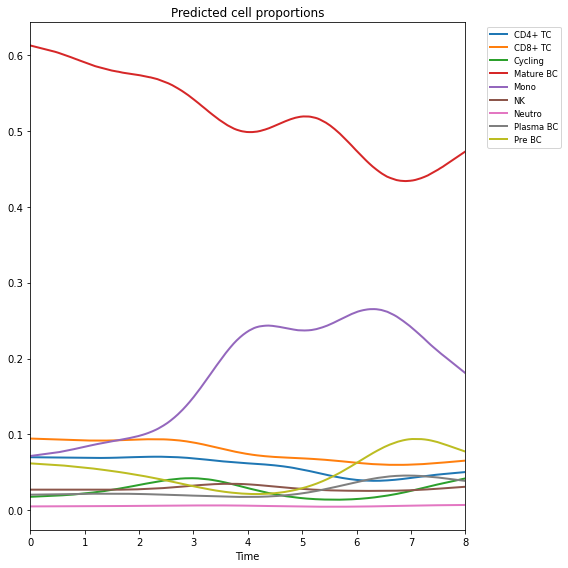

In [12]:
from ternadecov.deconvolution_exporter import DeconvolutionExporter
exporter = DeconvolutionExporter(pseudo_time_reg_deconv, prefix = 'spleen_')
exporter.export_results('output/spleen/')